Extracting file from zipfile

In [1]:
import zipfile

#  path to the ZIP file
zip_file_path = "C:/Users/ragha/Desktop/Projects/Face-mask-detection/mask_images_ready.zip"
destination_folder = "C:/Users/ragha/Desktop/Projects/Face-mask-detection/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


print("Folder extraction completed.")

Folder extraction completed.


Import necessary packages and libraries


In [2]:
import os
import cv2 #OpenCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

Check is CUDA is accessible - To use GPU instead of CPU

In [3]:
torch.cuda.is_available()

True

Changing the device from CPU to Cuda

In [4]:
device = torch.device("cuda")

FaceMaskDataset class for training, validation, and test data

In [5]:
class FaceMaskDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

# OpenCV reads the image from the given image path and converts colour space from BGR to RGB. Then resizes it.

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
#transform is imported from torchvision
#Converts to PIL - Python Imaging Library. IT is the original library that enabled Python to deal with images
#Transformation process - Converts to PIL -> Resizing -> Converts to Tensor -> Normalize

class FaceMaskDetector:
    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.load_model(model_path).to(self.device)
        self.transform = transforms.Compose([   
            transforms.ToPILImage(), 
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# ResNet-50 is a convolutional neural network that is 50 layers deep. The pretrained=False argument ensures that the model is not loaded with pre-trained weights.
# num_features line retrieves the number of input features of the last fully connected layer (fc) of the model.
# model.fc replaces the last fully connected layer (fc) of the model with a new linear layer (nn.Linear) having num_features input features and 2 output features (mask vs. no mask).
# Then these changes are laoded and evaluated

    def load_model(self, model_path):
        model = models.resnet50(weights=False)
        num_features = model.fc.in_features   
        model.fc = nn.Linear(num_features, 2) 
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.eval()
        return model
    
# image frame is taken as input
# It applies the defined image transformations and converts the frame to a tensor.
# No gradient calculation is done to speed up computation
# Probabilities are obtained from the softmax function
# mask_probability retrieves the probability value corresponding to the "Mask" class 
# no_mask_probability retrieves the probability value corresponding to the "No Mask" class 
# Whatever probability is greater, it returns that label

    def detect(self, frame):
        frame = self.transform(frame).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(frame)
        probabilities = torch.softmax(output, dim=1)[0]
        mask_probability = probabilities[1].item()
        no_mask_probability = probabilities[0].item()
        label = "Mask" if mask_probability > no_mask_probability else "No Mask"
        return label

The training directory paths


In [7]:
train_data_dir = "C:/Users/ragha/Desktop/Projects/Face-mask-detection/mask_images_ready/train"
val_data_dir = "C:/Users/ragha/Desktop/Projects/Face-mask-detection/mask_images_ready/val"
test_data_dir = "C:/Users/ragha/Desktop/Projects/Face-mask-detection/mask_images_ready/test"
model_save_path = "C:/Users/ragha/Desktop/Projects/Face-mask-detection/Final_FaceMask_detection_model.pt"

Load the training data

In [8]:
train_image_paths = []
train_labels = []

for folder_name in os.listdir(train_data_dir):
    folder_path = os.path.join(train_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png") or file_name.endswith(".jpg"): 
                file_path = os.path.join(folder_path, file_name)
                train_image_paths.append(file_path)
                train_labels.append(1 if folder_name == "1" else 0)


Load the validation data

In [9]:
val_image_paths = []
val_labels = []


for folder_name in os.listdir(val_data_dir):
    folder_path = os.path.join(val_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png") or file_name.endswith(".jpg"):
                file_path = os.path.join(folder_path, file_name)
                val_image_paths.append(file_path)
                val_labels.append(1 if folder_name == "1" else 0)


Load the test data

In [10]:
test_image_paths = []
test_labels = []

for folder_name in os.listdir(test_data_dir):
    folder_path = os.path.join(test_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png") or file_name.endswith(".jpg"):
                file_path = os.path.join(folder_path, file_name)
                test_image_paths.append(file_path)
                test_labels.append(1 if folder_name == "1" else 0)

FaceMaskDataset class for training, validation, and test data

In [11]:
train_dataset = FaceMaskDataset(train_image_paths, train_labels, transform=transforms.ToTensor())
val_dataset = FaceMaskDataset(val_image_paths, val_labels, transform=transforms.ToTensor())
test_dataset = FaceMaskDataset(test_image_paths, test_labels, transform=transforms.ToTensor())


In [12]:
batch_size = 16
num_epochs = 16

Training, validation, and test data loaders

In [13]:
#  DataLoader is a class that provides an interface to efficiently load in mini batches and process data from a dataset. 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

FaceMaskModel class

In [14]:
# FaceMaskModel class in herits a Neural Network module
# Here the model creates an instance of the ResNet-50 model and uses the pretrained weights on the ImageNet dataset
# Here also we replace the last fully connected layer (fc) of the model with a new linear layer (nn.Linear) having num_features input features and 2 output features (mask vs. no mask).

class FaceMaskModel(nn.Module):
    def __init__(self):
        super(FaceMaskModel, self).__init__()
        self.model = models.resnet50(weights=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.model(x)

# FaceMaskModel class
model = FaceMaskModel()

c:\Users\ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The loss function, optimizer, and learning rate scheduler

In [15]:
# Cross-Entropy loss is a most important cost function. It is used to optimize classification models (Not only Binary). Score/loss is calculated that penalizes the probability based on how far it is from the actual expected value. The penalty is logarithmic in nature.
criterion = nn.CrossEntropyLoss()

# Adam optimization is a extension stochastic gradient descent method. It is more successful in finding Global Minimas compared to other gradient descent methods. The optimizer is responsible for updating the model's parameters during training based on the calculated gradients. It takes as input the model's parameters. lr -> Learning Rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# The scheduler adjusts the learning rate during training to improve convergence and performance. In this case, it applies a step-wise decay to the learning rate. In this case after every 3 epochs, the learning rate is multiplied by 0.1, reducing it by a factor of 10.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# This line moves the model to the specified device - GPU or CPU
model = model.to(device)

Training the Model

In [16]:
# list to save the train loss and accuracy for plotting
train_loss_values = []
train_accuracy_values = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()


    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    train_loss_values.append(train_loss)  # Append train loss value to the list
    train_accuracy_values.append(train_accuracy)  # Append train accuracy value to the list

    # Model evaluation on the validation data
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad(): 
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_accuracy = val_correct / val_total
    val_loss = val_loss / len(val_loader)


    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy*100:.2f}%")
    print("-------------------------------")

Epoch 1/16
Train Loss: 0.3676 | Train Accuracy: 85.80%
Val Loss: 0.3634 | Val Accuracy: 92.06%
-------------------------------
Epoch 2/16
Train Loss: 0.2479 | Train Accuracy: 90.74%
Val Loss: 6.9154 | Val Accuracy: 63.49%
-------------------------------
Epoch 3/16
Train Loss: 0.2476 | Train Accuracy: 90.43%
Val Loss: 0.2252 | Val Accuracy: 95.24%
-------------------------------
Epoch 4/16
Train Loss: 0.1306 | Train Accuracy: 95.68%
Val Loss: 0.0805 | Val Accuracy: 96.83%
-------------------------------
Epoch 5/16
Train Loss: 0.0650 | Train Accuracy: 97.53%
Val Loss: 0.1003 | Val Accuracy: 95.24%
-------------------------------
Epoch 6/16
Train Loss: 0.1718 | Train Accuracy: 92.59%
Val Loss: 0.3096 | Val Accuracy: 90.48%
-------------------------------
Epoch 7/16
Train Loss: 0.2289 | Train Accuracy: 95.06%
Val Loss: 0.1301 | Val Accuracy: 98.41%
-------------------------------
Epoch 8/16
Train Loss: 0.0876 | Train Accuracy: 97.22%
Val Loss: 0.3014 | Val Accuracy: 87.30%
----------------

Plotting train loss and accuracy

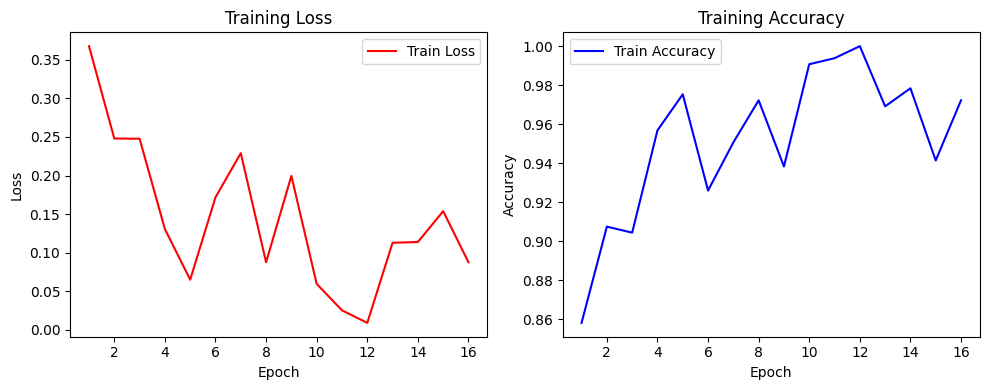

In [17]:
# list of epoch numbers
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 4))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train Loss', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
# plt.show()

# Plot train accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_values, label='Train Accuracy', color="blue")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
# plt.show()

plt.tight_layout()
plt.show()

Save the trained model

In [18]:
torch.save(model.state_dict(), model_save_path)

# Model evaluation on test data
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = test_correct / test_total
test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")

# save the model one more time after checking good accuracy
torch.save(model.state_dict(), model_save_path)

Test Loss: 0.0501 | Test Accuracy: 96.92%
